In [93]:
import pandas as pd
import numpy as np
import os
from os.path import isfile, join
import xml.etree.ElementTree as ET
import copy
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["errorbar.capsize"] = 8.
#rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = '14'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [96]:
main_folder = '../data/online/instance21/iterations/'
iteration_folders = [os.path.join(main_folder, i) for i in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, i))]

In [3]:
def get_data(tree, d):
    for meas in tree:
        m = meas.attrib
        ev_id = int(m['id'])
        data = d[ev_id]
        data['init_time'].append(float(m['init_operation_time']))
        data['end_time'].append(float(m['arrival_time']))
        data['consumption'].append(float(m['consumption_since_start']))
        data['total_time'].append(float(m['arrival_time']) - float(m['init_operation_time']))
    return d

In [4]:
data0 = {'init_time': [], 'end_time': [], 'total_time':[], 'consumption': []}
data1 = {'init_time': [], 'end_time': [], 'total_time':[], 'consumption': []}
opt_data = {0: data0, 1: data1}
nopt_data = copy.deepcopy(opt_data)
for iteration_folder in iteration_folders:
    # with opt
    path = iteration_folder +'/opt/collection.xml'
    opt_tree = ET.parse(path).getroot()
    opt_data = get_data(opt_tree, opt_data)
    
    
    # without opt
    path = iteration_folder +'/no_opt/collection.xml'
    no_opt_tree = ET.parse(path).getroot()
    no_opt_data = get_data(no_opt_tree, nopt_data)
    
opt0_df = pd.DataFrame(opt_data[0])
opt1_df = pd.DataFrame(opt_data[1])
nopt0_df = pd.DataFrame(no_opt_data[0])
nopt1_df = pd.DataFrame(no_opt_data[1])

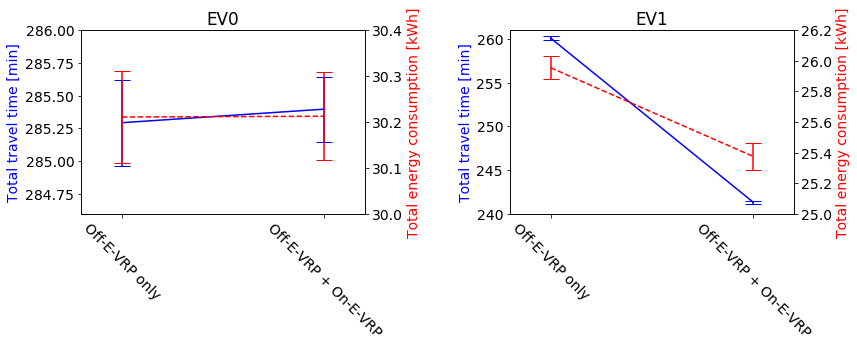

In [97]:
fig, (axtime, axec) = plt.subplots(1, 2, figsize=(12,5))

# EV 0
id_ev = 0

avg_time_opt = np.mean(opt_data[id_ev]['total_time'])
std_time_opt = np.std(opt_data[id_ev]['total_time'])
avg_time_nopt = np.mean(nopt_data[id_ev]['total_time'])
std_time_nopt = np.std(nopt_data[id_ev]['total_time'])

avg_ec_opt = np.mean(opt_data[id_ev]['consumption'])
std_ec_opt = np.std(opt_data[id_ev]['consumption'])
avg_ec_nopt = np.mean(nopt_data[id_ev]['consumption'])
std_ec_nopt = np.std(nopt_data[id_ev]['consumption'])

ax0 = axtime
ax1 = ax0.twinx()

ax0.errorbar([0, 1], [avg_time_nopt, avg_time_opt], [std_time_nopt, std_time_opt], color='b')
ax1.errorbar([0, 1], [avg_ec_nopt, avg_ec_opt], [std_ec_nopt, std_ec_opt], color='r', linestyle='--', fmt='--')

ax0.set_ylabel('Total travel time [min]', color='b')
ax1.set_ylabel('Total energy consumption [kWh]', color='r')

ax0.set_xticks([0, 1])
ax0.set_xticklabels(['Off-E-VRP only', 'Off-E-VRP + On-E-VRP'], rotation=-45)

ax0.set_ylim(284.6, 286)
ax1.set_ylim(30., 30.4)

ax0.set_xlim(-.2, 1.2)

ax0.set_title(f'EV{id_ev}')

# EV 1
id_ev = 1

avg_time_opt = np.mean(opt_data[id_ev]['total_time'])
std_time_opt = np.std(opt_data[id_ev]['total_time'])
avg_time_nopt = np.mean(nopt_data[id_ev]['total_time'])
std_time_nopt = np.std(nopt_data[id_ev]['total_time'])

avg_ec_opt = np.mean(opt_data[id_ev]['consumption'])
std_ec_opt = np.std(opt_data[id_ev]['consumption'])
avg_ec_nopt = np.mean(nopt_data[id_ev]['consumption'])
std_ec_nopt = np.std(nopt_data[id_ev]['consumption'])

ax0 = axec
ax1 = ax0.twinx()

l0 = ax0.errorbar([0, 1], [avg_time_nopt, avg_time_opt], [std_time_nopt, std_time_opt], color='b', label='Total travel time')
l1 = ax1.errorbar([0, 1], [avg_ec_nopt, avg_ec_opt], [std_ec_nopt, std_ec_opt], fmt='r--', label='Total energy consumption')

ax0.set_ylim(240, 261)
ax1.set_ylim(25, 26.2)

ax0.set_xlim(-.2, 1.2)

ax0.set_ylabel('Total travel time [min]', color='b')
ax1.set_ylabel('Total energy consumption [kWh]', color='r')

ax0.set_xticks([0, 1])
ax0.set_xticklabels(['Off-E-VRP only', 'Off-E-VRP + On-E-VRP'], rotation=-45)

ax0.set_title(f'EV{id_ev}')

plt.tight_layout()
plt.show()
fig.savefig(main_folder+'comparison.pdf')

In [6]:
nopt1_df

,init_time,end_time,total_time,consumption
0,796.298401,1057.068575,260.770174,25.937423
1,796.298401,1056.324698,260.026296,26.032449
2,796.298401,1056.388213,260.089812,25.857449
3,796.298401,1056.488585,260.190184,25.995363
4,796.298401,1056.157120,259.858719,26.069678
5,796.298401,1056.189871,259.891470,25.846442
6,796.298401,1056.069887,259.771486,25.944040
7,796.298401,1056.471994,260.173593,25.881444
8,796.298401,1056.202240,259.903839,25.969318
9,796.298401,1056.592579,260.294177,25.887213
